# StackOverflow Survey Analysis on Data Science Related Roles

## About

This notebook aims to understand some differences between Data Science related roles from a more subjective perspective. It's based on the 2020 [StackOverflow Developer Survey](https://insights.stackoverflow.com/survey). For a summary of the results, please check out my [medium post](www.medium.com) (although the code for making the charts are available here, I didn't use them. I made the charts with PowerPoint, because it is much more practical).

The analysis here is intend to answer three main questions regarding the idiosyncrasies of Data Analysts, Data Scientists and Data Engineers:
1. Which data role is most satisfied with its job?
2. What are the main drivers each one looks for in a new job?
3. What are the most important factors each one considers in a job position?

## Preparing and Understanding the Dataset

We'll start by importing Numpy, Pandas and Seaborn, and understanding basic information about the survey.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Reading datasets
schema = pd.read_csv('data/survey_results_schema.csv')
results = pd.read_csv('data/survey_results_public.csv')

n_respondents = results.shape[0]
print(f'There were {n_respondents} in the survey results.')

There were 64461 in the survey results.


In order to filter the survey respondents to keep only those working on Data Science, we start by listing all the possible job titles available in the checkbox list.

In [3]:
# Listing all developer roles
results['DevType'].str.split(';').explode().value_counts()

Developer, back-end                              27228
Developer, full-stack                            27125
Developer, front-end                             18296
Developer, desktop or enterprise applications    11784
Developer, mobile                                 9482
DevOps specialist                                 5969
Database administrator                            5722
Designer                                          5321
System administrator                              5242
Developer, embedded applications or devices       4750
Data or business analyst                          4024
Data scientist or machine learning specialist     3988
Developer, QA or test                             3947
Engineer, data                                    3738
Academic researcher                               3552
Educator                                          2928
Developer, game or graphics                       2789
Engineering manager                               2724
Product ma

With all the possible developer roles listed above, we can filter our dataframe to keep only respondents working in a data science related role. Since we will be interested in comparing differences between them, we will keep only respondents that checked only one of the three roles ("Data or business analyst", "Data scientist or machine learning specialist", and "Engineer, data.")

In [4]:
# Filtering only respondents of DevType with a Data Science related role
dsr_df = results.copy()
dsr_roles = [
    'Data or business analyst',
    'Data scientist or machine learning specialist',
    'Engineer, data'
]
dsr_df = pd.concat([dsr_df, dsr_df['DevType'].str.get_dummies(sep=';')[dsr_roles]], axis=1)
dsr_df = dsr_df[dsr_df[dsr_roles].any(axis=1)]

# Keeping only respondents with a single data science related role
dsr_df = dsr_df[dsr_df[dsr_roles].sum(axis=1)==1]
dsr_df = pd.concat(
    [dsr_df.drop(columns=dsr_roles), dsr_df[dsr_roles].idxmax(axis=1)],
    axis=1
).rename(columns={0: 'DSRole'})

n_respondents_dsr = dsr_df.shape[0]
print('Respondents working with data science related roles:')
print('{} ({:.0%} of {})'.format(n_respondents_dsr, n_respondents_dsr / n_respondents, n_respondents))

dsr_df['DSRole'].value_counts(normalize=True)

Respondents working with data science related roles:
6272 (10% of 64461)


Data or business analyst                         0.348852
Data scientist or machine learning specialist    0.330517
Engineer, data                                   0.320631
Name: DSRole, dtype: float64

In [5]:
dsr_df.dropna(subset=['JobSat'])['DSRole'].value_counts()

Data or business analyst                         1904
Engineer, data                                   1850
Data scientist or machine learning specialist    1822
Name: DSRole, dtype: int64

We can see that we have a balanced dataset with approximately a uniform distribution of respondents among the three data science related roles. So now we can start answering the questions we posed.

### 1. Which data role is most satisfied with its job?

We can answer this question looking at the different values for job satisfaction per role.

In [6]:
# Creating a dataframe of the amount of respondents per role in the rows and satisfaction in the columns
likert_sat = dsr_df.groupby(['DSRole', 'JobSat'])['Respondent'].count().reset_index()
likert_sat = likert_sat.pivot(index='DSRole', columns='JobSat', values='Respondent')
likert_sat.columns = likert_sat.columns.values

# Ordering rows and columns
sat_vals = ['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied','Very satisfied']
dsr_order = ['Data scientist or machine learning specialist', 'Engineer, data', 'Data or business analyst']
likert_sat = likert_sat.loc[dsr_order, sat_vals]
likert_sat

,Very dissatisfied,Slightly dissatisfied,Neither satisfied nor dissatisfied,Slightly satisfied,Very satisfied
DSRole,,,,,
Data scientist or machine learning specialist,145,231,181,555,710
"Engineer, data",136,297,227,570,620
Data or business analyst,161,332,250,561,600


,Very dissatisfied,Slightly dissatisfied,Neither satisfied nor dissatisfied,Slightly satisfied,Very satisfied
DSRole,,,,,
Data scientist or machine learning specialist,7.958288,12.678375,9.934138,30.461032,38.968167
"Engineer, data",7.351351,16.054054,12.270270,30.810811,33.513514
Data or business analyst,8.455882,17.436975,13.130252,29.464286,31.512605


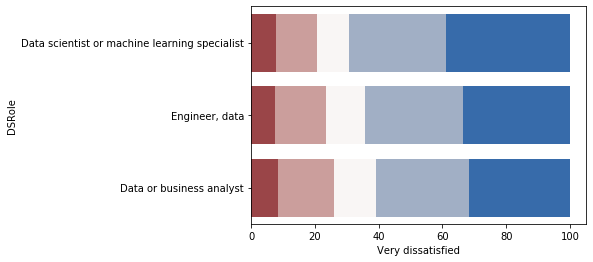

In [7]:
# Cumulative summing and normalizing to create a stacked bar chart
likert_sat = 100 * likert_sat.div(likert_sat.sum(axis=1), axis=0)
display(likert_sat)
likert_sat = likert_sat.cumsum(axis=1)

# Plotting
colors = sns.color_palette("vlag", as_cmap=True)
for idx, sat_val in enumerate(sat_vals[::-1]):
    _ = sns.barplot(x=sat_val, y='DSRole', data=likert_sat.reset_index(), color=colors(idx/(len(sat_vals)-1)))

It's clear that data scientists or machine learning speaclist are the ones most satisfied with their jobs. However, we don't have a single metric to compare them, since the column containing the job satiscation ```JobSat``` isn't numeric. We can then assign a numeric value to each possible response.

,DSRole,JobSatNum
0,Data or business analyst,-0.050004
1,Data scientist or machine learning specialist,0.166613
2,"Engineer, data",0.039400


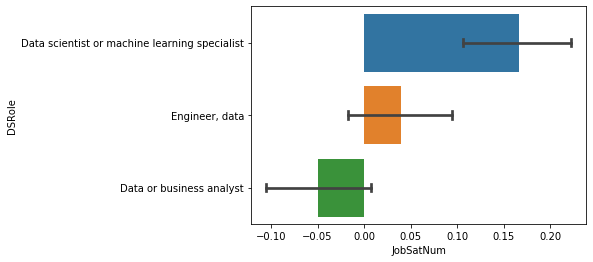

In [8]:
# Transforming JobSat in numeric data
sat_map = {
    'Very dissatisfied': -2,
    'Slightly dissatisfied': -1,
    'Neither satisfied nor dissatisfied': 0,
    'Slightly satisfied': 1,
    'Very satisfied': 2
}
avg_sat = results['JobSat'].replace(sat_map).astype(float).mean()
dsr_df['JobSatNum'] = dsr_df['JobSat'].replace(sat_map).astype(float) - avg_sat

# Grouping by role
avg_sat_dsr = dsr_df.groupby('DSRole')['JobSatNum'].mean()
display(avg_sat_dsr.reset_index())

_ = sns.barplot(
    x='JobSatNum',
    y='DSRole',
    data=dsr_df,
    capsize=.1,
    order=avg_sat_dsr.sort_values(ascending=False).index.values
)

In [9]:
bs_reps_size = 1000    # amount of bootstrap replicates
job_sat_bs_reps = {}   # bootstrap replicates per role

for role in dsr_roles:
    bs_reps = np.empty(bs_reps_size)
    
    # Get the original data of the numeric job satisfaction
    data = dsr_df.loc[dsr_df['DSRole']==role, 'JobSatNum'].dropna().values
    print(f'{data.shape[0]} respondents with role {role}')
    
    # Generate bootstrap replicates of the mean
    for i in range(bs_reps_size):
        bs_reps[i] = np.random.choice(data, data.shape[0]).mean()
    
    job_sat_bs_reps[role] = bs_reps

# Get the median and 95% confidence interval of the job satisfaction per role
job_sat_bs_reps = pd.DataFrame(job_sat_bs_reps)
job_sat_bs_reps.describe(percentiles=[0.025, 0.5, 0.975]).loc[['2.5%','50%','97.5%'], dsr_order].T

1904 respondents with role Data or business analyst
1822 respondents with role Data scientist or machine learning specialist
1850 respondents with role Engineer, data


,2.5%,50%,97.5%
Data scientist or machine learning specialist,0.104566,0.166064,0.229209
"Engineer, data",-0.017898,0.040481,0.095643
Data or business analyst,-0.113554,-0.049741,0.009371


From the above data, we see that Data Scientists or Machine Learning Specialists are the happiest with a significant margin, followed by Data Engineers and lastly by Data or Business Analysts.

### 2. What are the main drivers each one looks for in a new job?

In the survey, respondents were asked "in general, what drives you to look for a new job?". Since they could select multiple choices, we must transform the data appropriately.

In [10]:
# Transforming (exploding) NEWJobHunt column
newjobhunt_df = dsr_df[['Respondent', 'DSRole', 'NEWJobHunt']].copy().dropna(subset=['NEWJobHunt'])
newjobhunt_df['NEWJobHunt'] = newjobhunt_df['NEWJobHunt'].str.split(';')
newjobhunt_df = newjobhunt_df.explode('NEWJobHunt')

# Counting and ordering drivers for new job hunt
rank_newjobhunt = newjobhunt_df.groupby(['DSRole','NEWJobHunt'])['Respondent'].count().reset_index()
rank_newjobhunt = rank_newjobhunt.sort_values(['DSRole','Respondent'], ascending=False)
rank_newjobhunt['Rank'] = rank_newjobhunt.groupby('DSRole').cumcount() + 1

# Pivoting dataframe
rank_newjobhunt.pivot(index='Rank', columns='DSRole', values='NEWJobHunt')

DSRole,Data or business analyst,Data scientist or machine learning specialist,"Engineer, data"
Rank,,,
1,Better compensation,Better compensation,Better compensation
2,Growth or leadership opportunities,Curious about other opportunities,Wanting to work with new technologies
3,Wanting to work with new technologies,Growth or leadership opportunities,Curious about other opportunities
4,Curious about other opportunities,Wanting to work with new technologies,Growth or leadership opportunities
5,Better work/life balance,Better work/life balance,Better work/life balance
6,Trouble with leadership at my company,Looking to relocate,Looking to relocate
7,Looking to relocate,Trouble with leadership at my company,Trouble with leadership at my company
8,Having a bad day (or week or month) at work,Having a bad day (or week or month) at work,Having a bad day (or week or month) at work
9,Trouble with my direct manager,Trouble with my direct manager,Trouble with my direct manager


In [49]:
rank_newjobhunt.pivot(index='DSRole', columns='NEWJobHunt', values='Respondent') \
               .div(dsr_df.dropna(subset=['NEWJobHunt'])['DSRole'].value_counts(), axis=0)

NEWJobHunt,Better compensation,Better work/life balance,Curious about other opportunities,Growth or leadership opportunities,Having a bad day (or week or month) at work,Just because,Looking to relocate,Trouble with leadership at my company,Trouble with my direct manager,Trouble with my teammates,Wanting to share accomplishments with a wider network,Wanting to work with new technologies
DSRole,,,,,,,,,,,,
Data or business analyst,0.696387,0.455128,0.562354,0.572844,0.192308,0.146270,0.244755,0.245338,0.157343,0.090326,0.131119,0.566434
Data scientist or machine learning specialist,0.659224,0.435958,0.595182,0.560517,0.183314,0.133373,0.275558,0.243831,0.153937,0.099295,0.115159,0.548766
"Engineer, data",0.701430,0.488081,0.600119,0.571514,0.204410,0.137068,0.297974,0.289035,0.195471,0.126341,0.128725,0.631704


In [11]:
bs_reps_size = 1000    # amount of bootstrap replicates
newjob_bs_reps = []    # bootstrap replicates per role

for idx, role in enumerate(dsr_roles):
    bs_reps = [None] * bs_reps_size
    
    # Get only respondents with the current role
    data = dsr_df.loc[dsr_df['DSRole']==role, 'NEWJobHunt'].dropna()
    print(f'{data.shape[0]} respondents with role {role}')
    
    # Generate bootstrap replicates
    for i in range(bs_reps_size):
        # Bootstrap respondents (same size, with replacement)
        bs_data = data.sample(frac=1, replace=True)
        
        # Transforming (exploding) NEWJobHunt column
        bs_data = bs_data.str.split(';').explode()
        bs_reps[i] = bs_data.value_counts()
    
    # Construct DataFrame with samples in rows and job drivers in columns
    # Should divide by number of respondents to get percentages
    aux_df = pd.DataFrame(bs_reps).fillna(0) / data.shape[0]
    aux_df['DSRole'] = role
    newjob_bs_reps.append(aux_df)
    
# Concatenate bootstrap replicates for all job roles
newjob_bs_reps = pd.concat(newjob_bs_reps).reset_index(drop=True)

1716 respondents with role Data or business analyst
1702 respondents with role Data scientist or machine learning specialist
1678 respondents with role Engineer, data


In [40]:
# Get the median and 95% confidence interval for each driver
newjob_main_drivers = [
    'Better compensation',
    'Growth or leadership opportunities',
    'Wanting to work with new technologies',
    'Curious about other opportunities'
]
percentiles_plot = ['2.5%','50%','97.5%']
cols = [(driver, perc) for driver in newjob_main_drivers for perc in percentiles_plot]
newjob_bs_reps.groupby('DSRole').describe(percentiles=[0.025, 0.5, 0.975])[cols]

Better compensation            \
                                                             2.5%       50%   
DSRole                                                                        
Data or business analyst                                 0.675408  0.695804   
Data scientist or machine learning specialist            0.636898  0.659812   
Engineer, data                                           0.678784  0.701132   

                                                         \
                                                  97.5%   
DSRole                                                    
Data or business analyst                       0.717395   
Data scientist or machine learning specialist  0.682726   
Engineer, data                                 0.722303   

                                              Growth or leadership opportunities  \
                                                                            2.5%   
DSRole                                                                             
Data or business analyst                                                0.550117   
Data scientist or machine learning specialist                           0.538176   
Engineer, data                                                          0.547065   

                                                                   \
                                                    50%     97.5%   
DSRole                                                              
Data or business analyst                       0.572844  0.597319   
Data scientist or machine learning specialist  0.560517  0.585209   
Engineer, data                                 0.572110  0.594756   

                                              Wanting to work with new technologies  \
                                                                               2.5%   
DSRole                                                                                
Data or business analyst                                                   0.543109   
Data scientist or machine learning specialist                              0.524677   
Engineer, data                                                             0.609058   

                                                                   \
                                                    50%     97.5%   
DSRole                                                              
Data or business analyst                       0.565851  0.589758   
Data scientist or machine learning specialist  0.548766  0.571695   
Engineer, data                                 0.632300  0.654350   

                                              Curious about other opportunities  \
                                                                           2.5%   
DSRole                                                                            
Data or business analyst                                               0.540778   
Data scientist or machine learning specialist                          0.569918   
Engineer, data                                                         0.577458   

                                                                   
                                                    50%     97.5%  
DSRole                                                             
Data or business analyst                       0.562354  0.585082  
Data scientist or machine learning specialist  0.594595  0.618096  
Engineer, data                                 0.600119  0.623361

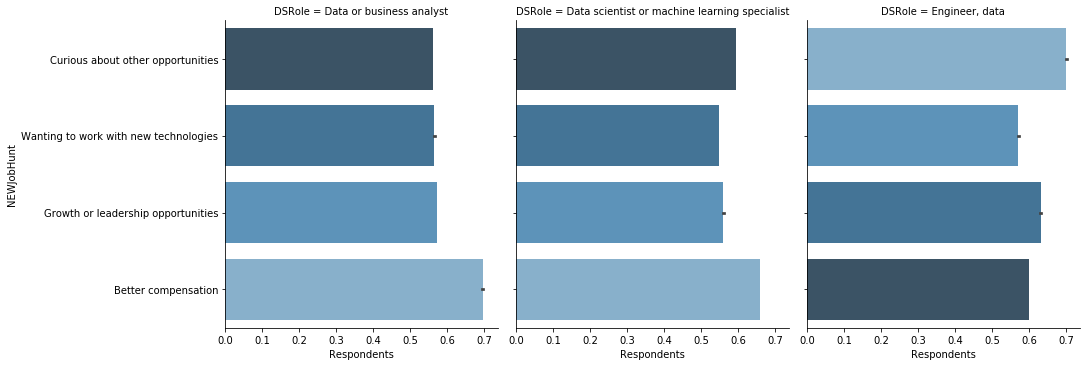

In [52]:
# WARNING: values for NEWJobHunt are not aligned for "Engineer, data"
_ = sns.catplot(
    x='Respondents',
    y='NEWJobHunt',
    col='DSRole',
    data=newjob_bs_reps[['DSRole']+newjob_main_drivers].melt(id_vars='DSRole', var_name='NEWJobHunt', value_name='Respondents'),
    kind='bar',
    palette='Blues_d',
    row_order=newjob_main_drivers
)

Unanimously, better compensation is the main driver for people working with data science (as it is overall for all respondents). Also, drivers below the fifth one are pretty similar to each one of them. The interesting part resides between the second and fourth drivers, which accurately represents aspects inherently present in each role.

Between "growth or leadership opportunities", "wanting to work with new technologies" and "curious about other opportunities":
* Data or Business Analysts value growth or leadership oportunities most. This might be a reflection of their aspirations in life, which tend to be more focused on the business aspects of problems and eventually embracing management positions.
* Data Scientists or Machine Learning Specialists are mostly driven in a new job because they're curious about other opportunities. Although this curiosity might include a broad range of aspects, it is indeed an important characteristic expected from them. They tend to pose questions and hypothesis, test them with the available data and solve hard problems using different approaches and algorithms.
* Data Engineers, on the other hand, are more passionate about working with new technologies. This trait is a reflection of their inclination towards the technical side of problems and using different tools to tackle them in an elegant and optimized way. Compared to the other two, they are the ones least interested in growth or leadership oportunities, which might be because this may lead them to become less hands-on in coding.

### 3. What are the most important factors each one considers in a job position?

Same as before, we need to transform the ```JobFactors``` column, since respondents could select more than one option to the question "imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?"

In [15]:
# Transforming (exploding) JobFactors column
jobfactors = dsr_df[['Respondent', 'DSRole', 'JobFactors']].copy().dropna(subset=['JobFactors'])
jobfactors['JobFactors'] = jobfactors['JobFactors'].str.split(';')
jobfactors = jobfactors.explode('JobFactors')

# Counting and ordering drivers for new job hunt
jobfactors = jobfactors.groupby(['DSRole','JobFactors'])['Respondent'].count().reset_index()
jobfactors = jobfactors.sort_values(['DSRole','Respondent'], ascending=False)
jobfactors['Rank'] = jobfactors.groupby('DSRole').cumcount() + 1

# Pivoting dataframe
jobfactors.pivot(index='Rank', columns='DSRole', values='JobFactors')

DSRole,Data or business analyst,Data scientist or machine learning specialist,"Engineer, data"
Rank,,,
1,Opportunities for professional development,Opportunities for professional development,"Languages, frameworks, and other technologies ..."
2,Flex time or a flexible schedule,"Languages, frameworks, and other technologies ...",Opportunities for professional development
3,Office environment or company culture,Flex time or a flexible schedule,Office environment or company culture
4,"Languages, frameworks, and other technologies ...",Office environment or company culture,Flex time or a flexible schedule
5,Remote work options,How widely used or impactful my work output wo...,Remote work options
6,How widely used or impactful my work output wo...,Remote work options,How widely used or impactful my work output wo...
7,Family friendliness,Industry that I’d be working in,Industry that I’d be working in
8,Industry that I’d be working in,Specific department or team I’d be working on,Financial performance or funding status of the...
9,Financial performance or funding status of the...,Family friendliness,Specific department or team I’d be working on


**interpretation**

In [16]:
jobseek = dsr_df[['Respondent','JobSeek','DSRole']].copy().dropna(subset=['JobSeek'])
jobseek = jobseek.groupby(['DSRole','JobSeek'])['Respondent'].count().reset_index().sort_values(['DSRole','Respondent'], ascending=False)
jobseek['Perc'] = jobseek['Respondent'] / jobseek.groupby('DSRole')['Respondent'].transform('sum')
jobseek

,DSRole,JobSeek,Respondent,Perc
8,"Engineer, data","I’m not actively looking, but I am open to new...",1037,0.568219
7,"Engineer, data",I am not interested in new job opportunities,509,0.278904
6,"Engineer, data",I am actively looking for a job,279,0.152877
5,Data scientist or machine learning specialist,"I’m not actively looking, but I am open to new...",1072,0.562434
4,Data scientist or machine learning specialist,I am not interested in new job opportunities,482,0.252886
3,Data scientist or machine learning specialist,I am actively looking for a job,352,0.184680
2,Data or business analyst,"I’m not actively looking, but I am open to new...",1197,0.612903
1,Data or business analyst,I am not interested in new job opportunities,428,0.219150
0,Data or business analyst,I am actively looking for a job,328,0.167947


### Other Analysis

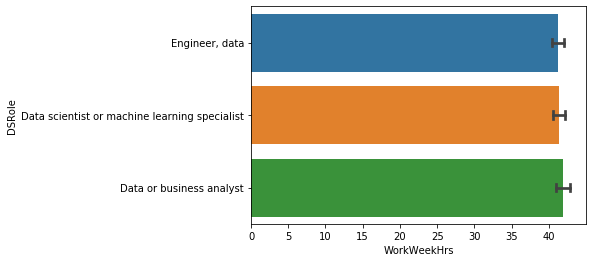

In [17]:
sns.barplot(
    x='WorkWeekHrs',
    y='DSRole',
    data=dsr_df,
    capsize=.1,
    order=dsr_df.groupby('DSRole')['WorkWeekHrs'].mean().sort_values().index.values
)

In [18]:
# Transforming YearsCode and YearsCodePro in numeric data
years_map = {'Less than 1 year': 0.5, 'More than 50 years': 50}
dsr_df['YearsCode'] = dsr_df['YearsCode'].replace(years_map).astype(float)
dsr_df['YearsCodePro'] = dsr_df['YearsCodePro'].replace(years_map).astype(float)

print(dsr_df.groupby('DSRole')['YearsCodePro'].mean())

DSRole
Data or business analyst                         10.677099
Data scientist or machine learning specialist     7.861443
Engineer, data                                    8.809791
Name: YearsCodePro, dtype: float64


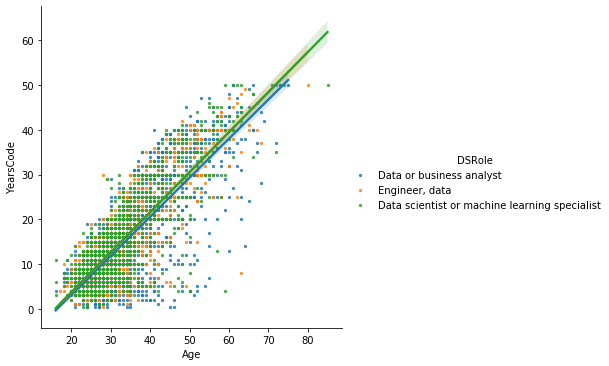

In [19]:
# Scatter plot of YearsCode x Age (for different DS Roles)
coding_years = dsr_df[['Age','YearsCode','YearsCodePro','DSRole']].copy().dropna()
coding_years = coding_years[coding_years['Age']>15]

_ = sns.lmplot(x='Age', y='YearsCode', hue='DSRole', data=coding_years, scatter_kws={"s": 5})

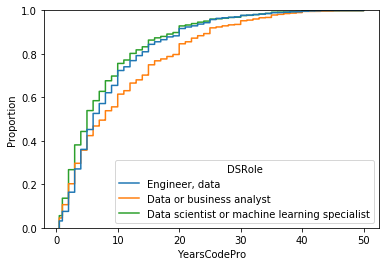

In [20]:
sns.ecdfplot(dsr_df, x='YearsCodePro', hue='DSRole')

## Interesting Columns
* [Country] Location
* [EdLevel] Highest level
* [UndergradMajor] Field of study
* [YearsCode or YearsCodePro] Years of coding
* [MainBranch] Type of developer
* [DevType] Developer role
* [JobSat] Job satisfaction
* [WorkWeekHrs] Work week hours
* [NEWJobHunt] Drivers for job hunt
* [NEWJobHuntResearch] Company research in job hunt
* [JobFactors] Job factors when deciding company (supposing same compensation, benefits, and locaiton)
* [NEWLearn] Frequency of learning new language/framework
* [DatabaseWorkedWith] Database environment with which worked in the past
* [DatabaseDesireNextYear] Database environment with which want to work next year
* [MiscTechWorkedWith] Database environment with which worked in the past
* [MiscTechDesireNextYear] Database environment with which want to work next year
* [SOComm] Member of the StackOverflow community

## Questions
* What are the main drivers for a DS job hunting 
* What are the job facors of a company in a DS job junt candidates are looking for
* Differences in job satisfaction among roles in DS
* Years of coding per DS job title
* Job satisfaction per occupation
* Database enironments for data engineers
* What are the most relevant associations of job roles for each one in DS

## Important
* Include original questions posed in the blog post
* Filter by MainBranch to get only those who code regularly
* Beware of selection bias
* Include premisses used for analysis